In [1]:
import torch

import triton
import triton.language as tl

CUDA GPU execution code achieves parallelism via the *single program, multiple data* (SPMD) paradigm. Under SPMD, 

### @triton.jit decorator

The `@triton.jit` decorator triggers [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation)-compilation of the decorated function. Triton jit'd functions are compiled and run on a GPU.  As written in the help doc, when "a jit'd function is called, `torch.tensor` arguments are implicitly converted to pointers using the `.data_ptr()` method." Further, they only have access to:

   * python primitives,
   * builtins within the triton package,
   * arguments to this function,
   * other jit'd functions
   
According to [this blog post](https://analyticssteps.com/blogs/openai-triton-programming-language-neural-networks), Triton kernels are single threaded, such that they process one command at a time. 

### Vector addition kernel

Below, we'll implement a vector addition kernel and decorate it with `@triton.jit`. 



The Triton class `constexpr` is used to store a value that is known at compile-time.

The Triton function `program_id` returns the id of the current program instance along the given `axis`. The axis referes to the axis of the 3D launch grid and it must be either 0, 1, or 2. For example, if your program uses a 1D launch grid, the axis should be 0. 




In [13]:
help(tl.program_id)

Help on function program_id in module triton.language.core:

program_id(axis, _builder=None)
    Returns the id of the current program instance along the given :code:`axis`.
    
    :param axis: The axis of the 3D launch grid. Has to be either 0, 1 or 2.
    :type axis: int



In [2]:
@triton.jit
def add_kernel(
    x_ptr,  # *Pointer* to first input vector
    y_ptr,  # *Pointer* to second input vector
    output_ptr,  # *Pointer* to output vector
    n_elements,  # Size of the vector
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process
                 # NOTE: `constexpr` so it can be used as a shape value
):
    # There are multiple 'program's processing different data. We identify which program
    # we are here
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0
    # This program will process inputs that are offset from the initial data.
    # for instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM
    tl.store(output_ptr + offsets, output, mask=mask)

In [3]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int]
    # In this case, we use a 1D grid where the size is the number of blocks
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    # NOTE:
    #  - each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be index with a launch grid to obtain a callable GPU kernel
    #  - don't forget to pass meta-parameters as keywords arguments
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

In [4]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f'The maximum difference between torch and triton is '
    f'{torch.max(torch.abs(output_torch - output_triton))}'
)

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # argument names to use as an x-axis for the plot
        x_vals=[
            2 ** i for i in range(12, 28, 1)
        ],  # different possible values for `x_name`
        x_log=True,  # x axis is logarithmic
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg`
        line_names=['Triton', 'Torch'],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel='GB/s',  # label name for the y-axis
        plot_name='vector-add-performance',  # name for the plot. Used also as a file name for saving the plot.
        args={},  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y))
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


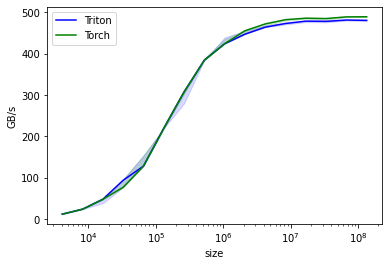

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   93.801531   76.800002
4       65536.0  127.999995  127.999995
5      131072.0  219.428568  219.428568
6      262144.0  307.200008  307.200008
7      524288.0  384.000001  384.000001
8     1048576.0  423.724127  423.724127
9     2097152.0  446.836360  455.111110
10    4194304.0  463.698115  471.623386
11    8388608.0  472.615390  481.882362
12   16777216.0  478.364979  485.451853
13   33554432.0  477.783730  484.554523
14   67108864.0  480.998167  488.599838
15  134217728.0  480.117211  488.922591


In [6]:
benchmark.run(print_data=True, show_plots=True)